# Convolutional VAE

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self, z_dim: int = 20):
        super().__init__()
        self.z_dim = z_dim

        # ----- Encoder -----
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, 2, 1),   # 28→14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),  # 14→7
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1), # 7→4
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, 2, 1),# 4→2
            nn.ReLU(),
            nn.Flatten()
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 1, 28, 28)
            h = self.encoder(dummy)
            self.flat_dim = h.shape[1]   # should be 1024

        # Latent projection
        self.fc_mu = nn.Linear(self.flat_dim, z_dim)
        self.fc_logvar = nn.Linear(self.flat_dim, z_dim)

        # ----- Decoder -----
        self.fc_decode = nn.Linear(z_dim, self.flat_dim)

        self.decoder = nn.Sequential(
            # 2 → 4
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(),

            # 4 → 7  (special layer!)
            nn.ConvTranspose2d(128, 64, 3, 2, 1, output_padding=0),
            nn.ReLU(),

            # 7 → 14
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),

            # 14 → 28
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparametrise(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(z.size(0), 256, 2, 2)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrise(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar
    
def vae_loss(
    recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor
) -> torch.Tensor:
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction="sum")

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [ ]:
train_dataset = datasets.MNIST(
    root="./mnist_data/", train=True, transform=transforms.ToTensor(), download=True
)
train_dataloader = DataLoader(train_dataset, batch_size=2048, shuffle=True, num_workers=4, pin_memory=True)
test_dataset = datasets.MNIST(
    root="./mnist_data/", train=False, transform=transforms.ToTensor(), download=True
)
test_dataloader = DataLoader(test_dataset, batch_size=2048, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = ConvVAE(z_dim=2).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

epochs = 100
best_validation_loss = np.inf
for e in range(epochs):
    vae.train()
    total_loss = 0

    for x, _ in train_dataloader:
        x = x.to(device)
        optimizer.zero_grad()
        x_recon, mu, logvar = vae(x)
        loss = vae_loss(x_recon, x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {e + 1}, Loss: {total_loss / len(train_dataloader.dataset):.4f}")

    vae.eval()
    validation_loss = 0
    first=True
    for x, _ in test_dataloader:
        x = x.to(device)
        x_recon, mu, logvar = vae(x)
        if first:
            print(f'{mu[0][0]:.4f} +/- {logvar[0][0]:.4f}')
            first=False
        loss = vae_loss(x_recon, x, mu, logvar)
        validation_loss += loss.item()
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        print(f'new best loss found: {validation_loss / len(test_dataloader.dataset):.4f}')
        torch.save(vae.state_dict(), 'vae_conv_mnist.pth')

    print(f"Epoch {e + 1}, Validation Loss: {validation_loss / len(test_dataloader.dataset):.4f}")

Epoch 1, Loss: 320.3174
1.1802 +/- -1.1820
new best loss found: 214.2615
Epoch 1, Validation Loss: 214.2615
Epoch 2, Loss: 210.9916
0.7582 +/- -1.9243
new best loss found: 208.7002
Epoch 2, Validation Loss: 208.7002
Epoch 3, Loss: 205.5251
0.4457 +/- -3.4966
new best loss found: 197.1774
Epoch 3, Validation Loss: 197.1774
Epoch 4, Loss: 193.5673
0.1813 +/- -3.5760
new best loss found: 190.4813
Epoch 4, Validation Loss: 190.4813
Epoch 5, Loss: 189.1148
-0.0067 +/- -4.0382
new best loss found: 186.8473
Epoch 5, Validation Loss: 186.8473
Epoch 6, Loss: 183.7591
-0.4333 +/- -3.6239
new best loss found: 177.6547
Epoch 6, Validation Loss: 177.6547
Epoch 7, Loss: 173.1347
-0.4997 +/- -4.7549
new best loss found: 169.8197
Epoch 7, Validation Loss: 169.8197
Epoch 8, Loss: 168.1605
-0.4994 +/- -5.1190
new best loss found: 167.7997
Epoch 8, Validation Loss: 167.7997
Epoch 9, Loss: 165.7467
-0.7408 +/- -5.2558
new best loss found: 164.1018
Epoch 9, Validation Loss: 164.1018
Epoch 10, Loss: 163.142

In [35]:
vae = ConvVAE(z_dim=2)
vae.load_state_dict(torch.load('vae_conv_mnist.pth'))
vae.eval()

ConvVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=1024, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=1024, out_features=2, bias=True)
  (fc_decode): Linear(in_features=2, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 

In [36]:
vae.eval()
for x, y in test_dataloader:
    x_recon, mu, logvar = vae(x)
    break

In [39]:
all_latent, all_sigma, all_latent_labels = [],[], []

for x, y in test_dataloader:
    all_latent += [vae.encode(x)[0]]
    all_sigma += [vae.encode(x)[1]]
    all_latent_labels += [y]

all_mu = torch.cat(all_latent, 0).detach().numpy()
all_sigma = torch.cat(all_sigma, 0).detach().numpy()
all_labels = torch.cat(all_latent_labels, 0).numpy()

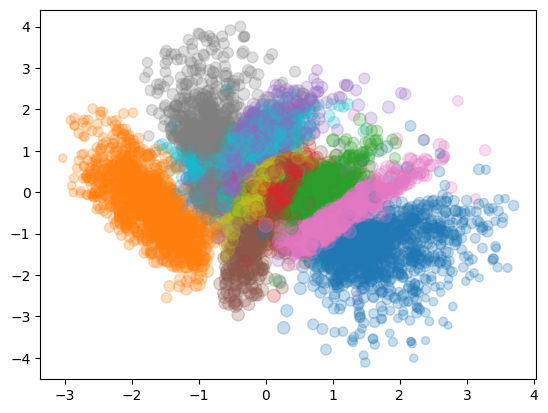

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(
    all_mu[:, 0], all_mu[:, 1], c = all_labels, cmap='tab10', alpha=0.25, s = (all_sigma[:, 0]**2 + all_sigma[:, 1]**2)
)
plt.show()

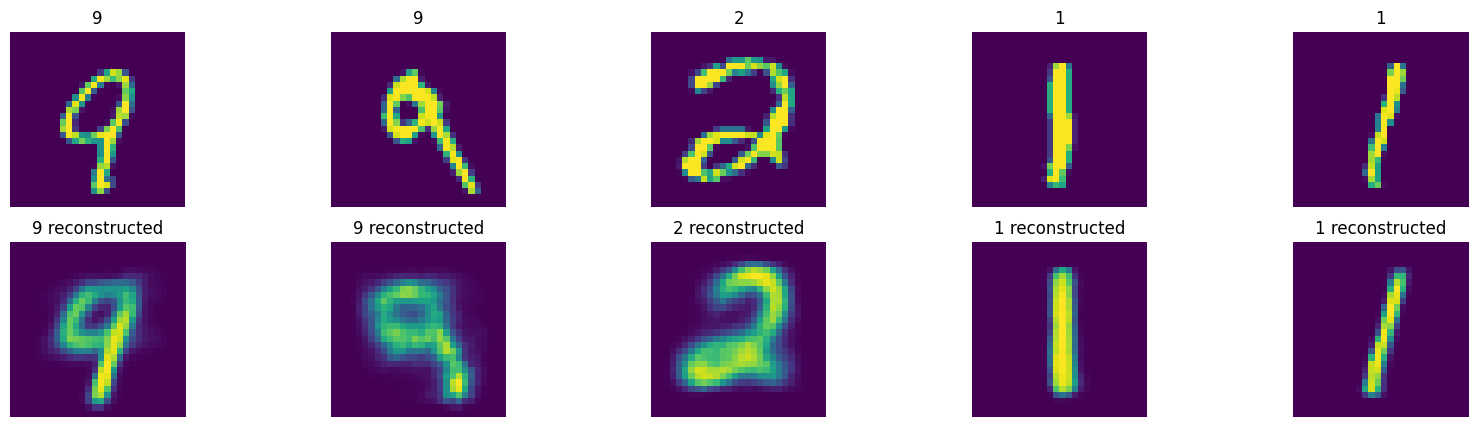

In [37]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 5))
for i in range(5):
    ind = np.random.randint(0, 128)
    plt.subplot(2, 5,i+1)
    plt.imshow(x[ind].numpy().reshape(28,28))
    plt.axis(False)
    plt.title(f'{y[ind]}')
    plt.subplot(2, 5,i+6)
    plt.imshow(x_recon[ind].detach().numpy().reshape(28,28))
    plt.axis(False)
    plt.title(f'{y[ind]} reconstructed')
plt.show()